In [1]:
import os
import sys
import shutil
import re
import copy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
if 'SUMO_HOME' in os.environ:
    sys.path.append(os.path.join(os.environ['SUMO_HOME'], 'tools'))
import traci
import traci.constants as tc
import sumolib
import xml.etree.ElementTree as ET

# Add the "scripts" directory to sys.path
current_dir = os.path.dirname(os.path.abspath("__file__"))
scripts_dir = os.path.abspath(os.path.join(current_dir, 'scripts'))
sys.path.append(scripts_dir)
import animateGPS
import importlib

FOLDER_NAME = 'town05'

In [2]:
sumoBinary = "/usr/bin/sumo-gui"
sumoCmd = [sumoBinary, "-c", "osm.sumocfg"]

In [3]:
# Code of each variable to subscribe:
SPEED = 64
POSITION = 66
ACCELERATION = 114
ANGLE = 67
DEPATURE = 58

In [4]:
def add_xml_child(file_path, parent_tag, child_tag, child_value, replace=True):
    """
    Adds a new child parameter inside a specified parent tag in the XML configuration file.
    If the parent tag does not exist, it creates a new parent tag (<parameter>) with the child.
    It also checks if the child element already exists to prevent duplicates.

    Args:
        file_path (str): Path to the XML configuration file.
        parent_tag (str): The parent tag under which to add the child (e.g., 'input').
        child_tag (str): The child tag to add (e.g., 'additional-files').
        child_value (str): The value to set for the new child tag.
        replace (bool): If True, replaces the existing child tag with the new value.
                        If False, adds another child value.
    Returns:
        bool: True if the addition was successful, False otherwise.
    """
    try:
        # Parse the XML file
        tree = ET.parse(file_path)
        root = tree.getroot()

        # Find the parent element by tag
        parent_elem = root.find(parent_tag)
        if parent_elem is None:
            print(f"Parent tag '{parent_tag}' not found. Creating new parent tag.")
            parent_elem = ET.Element(parent_tag)
            root.append(parent_elem)
            print(f"Created new parent tag <{parent_tag}>.")

        # Check if the child element already exists inside the parent element
        existing_child = parent_elem.find(child_tag)
        if existing_child is not None: 
            
            if existing_child.get('value') == child_value:
                print(f"Child <{child_tag}> with value '{child_value}' already exists. Skipping addition.")
                return False
            else:
                if replace:
                    print(f"Child <{child_tag}> already exists. Updating value to '{child_value}'.")
                    existing_child.set('value', child_value)
                else:
                    if child_value in existing_child.get('value').split(', '):
                        print(f"Child <{child_tag}> with value '{child_value}' already exists. Skipping addition.")
                        return False
                    
                    print(f"Child <{child_tag}> already exists. Adding another child with value '{child_value}'.")
                    existing_child.set('value', f'{existing_child.get("value")}, {child_value}')
                
                tree.write(file_path, encoding="UTF-8", xml_declaration=True, method="xml")
                print("XML file updated successfully.")
                return True

        # Create the new child element and set its value
        new_child = ET.Element(child_tag)
        new_child.set('value', child_value)
        print(f"Created <{child_tag}> with value '{child_value}'.")

        # Add the new child to the parent element
        parent_elem.append(new_child)
        print(f"Added <{child_tag}> to <{parent_tag}>.")

        # Write the updated XML to the file
        tree.write(file_path, encoding="UTF-8", xml_declaration=True, method="xml")
        print("XML file updated successfully.")
        return True

    except ET.ParseError as e:
        print(f"XML Parsing error: {e}")
        return False
    except Exception as e:
        print(f"An error occurred: {e}")
        return False

In [5]:
def flush_print():
    sys.stdout.write("\r")  # Move the cursor to the beginning of the line
    sys.stdout.write(" " * 50)  # Overwrite with spaces to clear the line
    sys.stdout.write("\r")  # Move back to the beginning again

In [18]:
def get_all_variables(vehIDs, personIDs, routine=None, delta_time=0.05, useGui=False, convertGeo=True, freeze_traffic_lights=False):
    """
    Function to get all variables from the simulation.
    :param vehIDs: List of vehicle IDs to subscribe to.
    :param personIDs: List of person IDs to subscribe to.
    :param routine: Dictionary with the routine of the vehicles.
    :param useGui: Boolean to use the GUI or not.
    :param convertGeo: Boolean to convert the coordinates from sumo to lat/lon (does not work when using maps from CARLA).
    :param freeze_traffic_lights: If true, traffic lights are green all the time.
    :return: Dictionary with the variables.
    """

    if useGui:
        traci.start(["sumo-gui", "-c", f"{FOLDER_NAME}/osm.sumocfg"])
    else:
        traci.start(["sumo", "-c", f"{FOLDER_NAME}/osm.sumocfg"])
    v_variables = {}
    p_variables = {}

    end_time = 24 * 60 * (60/0.05) # 24 hours
    add_xml_child(f'{FOLDER_NAME}/osm.sumocfg', 'time', 'step-length', f'{delta_time}', replace=True)
    add_xml_child(f'{FOLDER_NAME}/osm.sumocfg', 'time', 'end', f'{end_time}', replace=True)

    # Get all traffic light IDs
    if freeze_traffic_lights:
        tls_ids = traci.trafficlight.getIDList()

        # Set all traffic lights to constant green
        for tls_id in tls_ids:
            # Get logic info
            logic = traci.trafficlight.getCompleteRedYellowGreenDefinition(tls_id)[0]

            # Create a new green-only phase
            green_state = 'G' * len(logic.phases[0].state)
            green_phase = traci.trafficlight.Phase(duration=9999999, state=green_state)

            # Replace the logic with only this green phase
            new_logic = traci.trafficlight.Logic(
                logic.programID, logic.type, logic.currentPhaseIndex, [green_phase]
            )
            traci.trafficlight.setCompleteRedYellowGreenDefinition(tls_id, new_logic)
    
    # To understand when a car has changed its destionation, we need to know it parked
    if routine:
        status = {}
        for id in routine.keys():
            status[id] = {}
            status[id]['parked'] = False # True if the vehicle is parked
            status[id]['count'] = 0 # Count of number of times a vehicle has parked
            status[id]['stops'] = list(routine[id]['name']) # List of stops for the vehicle
            status[id]['desc'] = f'Vehicle heading to {status[id]["stops"][1]}' # Description of the vehicle's status

    time = 0
    while traci.simulation.getMinExpectedNumber() > 0:

        for veh_id in (set(traci.simulation.getDepartedIDList()) & set(vehIDs)): # Subscribe to vehicles that have just departed
            print(f"Vehicle {veh_id} has departed")
            traci.vehicle.subscribe(veh_id, [tc.VAR_POSITION, tc.VAR_SPEED, tc.VAR_ACCELERATION, tc.VAR_ANGLE])
        
        for veh_id in (set(traci.vehicle.getIDList()) & set(vehIDs)): # Checking status of vehicles that are already in the simulation
            if routine:
                is_parked = traci.vehicle.isStoppedParking(veh_id)
                current_location = status[veh_id]["stops"][status[veh_id]["count"]]
                next_location = status[veh_id]["stops"][status[veh_id]["count"] + 1] if status[veh_id]["count"] + 1 < len(status[veh_id]["stops"]) else None
                if not status[veh_id]['parked'] and is_parked:  # Vehicle was not parked and now is parked
                    status[veh_id]['parked'] = True
                    status[veh_id]['count'] += 1
                    status[veh_id]['desc'] = f'<{current_location},{current_location}>'

                elif status[veh_id]['parked'] and not is_parked:  # Vehicle was parked and now is not parked
                    status[veh_id]['parked'] = False
                    status[veh_id]['desc'] = f'<{current_location},{next_location}>'

        for veh_id in (set(traci.simulation.getArrivedIDList()) & set(vehIDs)): # Vehicles that finished their route
            # traci.vehicle.unsubscribe(veh_id)
            if routine:
                status[veh_id]['count'] += 1
                status[veh_id]['desc'] = f'<{current_location},{current_location}>'

        results = traci.vehicle.getAllSubscriptionResults().copy()

        for veh_id in results.keys():
            # Converting from x, y sumo coordinates to lat, lon
            if convertGeo:
                x, y = results[veh_id][tc.VAR_POSITION]
                lon, lat = traci.simulation.convertGeo(x, y, fromGeo=False)
                results[veh_id]['longitude'] = lon
                results[veh_id]['latitude'] = lat
                
            if routine:
                results[veh_id]['desc'] = status[veh_id]['desc']

        v_variables[time] = results
        
        time += delta_time
        traci.simulationStep()
        
    traci.close()
    return v_variables, p_variables

In [7]:
def get_departure_arrival(variables, ID):
    # Devolve o tempo de depareture e arrival de um veículo ou pessoa
    departure = 0
    arrival = 0
    departed = False
    arrived = False
    for x in range(len(variables)):
        if ID in variables[x] and variables[x][ID] and not departed:
            departed = True
            departure = x
        elif ID not in variables[x] and departed:
            arrival = x
            arrived = True
            break
    if not arrived:
        arrival = len(variables)
    return departure, arrival

In [9]:
def extract_vtype_ids(route_file_path, sulfix='veh'):
    # sulfix is the suffix of the vehicle ID to identify the vehicles from routines
    root = ET.parse(route_file_path).getroot()
    ids_random = {}
    ids_routine = {}
    for vehicle in (root.findall('vehicle') + root.findall('trip')):
        v_type = re.sub(r'\d+', '', vehicle.get('type').split('_', 1)[1])
        vID = vehicle.get('id')

        if vID.startswith(sulfix):
            if v_type not in ids_routine.keys():
                ids_routine[v_type] = []

            ids_routine[v_type].append(vID)

        else:
            if v_type not in ids_random.keys():
                ids_random[v_type] = []

            ids_random[v_type].append(vID)

    return ids_routine, ids_random

In [30]:
def plot_df(ids, df, sensors, normalize_time=True, time_window=[], use_lat_lon=True, save_path=None):

    fig, axes = plt.subplots(nrows=len(ids), ncols=2, figsize=(15, 5 * len(ids)))
    axes = axes.flatten()  # Flatten the axes array for easy indexing

    df["speed"] = df["speed"].values.astype(float)
    df["acceleration"] = df["acceleration"].values.astype(float)
    df["angle"] = df["angle"].values.astype(float)
    # Shift the time so that it starts at zero
    if normalize_time:
        df["timestamp"] = df["timestamp"] - df["timestamp"].min()
    
    # Limit the time window if specified
    if time_window:
        df = df[(df["timestamp"] >= time_window[0]) & (df["timestamp"] <= time_window[1])]

    if use_lat_lon:
        lat = df["latitude"].values
        lon = df["longitude"].values
    else:
        lat = df["y_pos"].values
        lon = df["x_pos"].values

    for i, veh_id in enumerate(ids):
        # Plot each selected sensor in its own subplot
        plot_line = i * 2
        for sensor in sensors:
            if sensor == 'gps':
                scatter = axes[plot_line + 1].scatter(lon, lat, c=df["timestamp"], cmap='viridis', label="Position (colored by time)", s=df["timestamp"] * 0.05)
                cbar = fig.colorbar(scatter, ax=axes[plot_line + 1])
                cbar.set_label("timestamp")
                axes[plot_line + 1].set_ylim(lat.min() - 0.001, lat.max() + 0.001)
                axes[plot_line + 1].set_xlim(lon.min() - 0.001, lon.max() + 0.001)
                axes[plot_line + 1].set_xlabel("x position")
                axes[plot_line + 1].set_ylabel("y position")
                axes[plot_line + 1].set_title(f"Vehicle position over time")
            else:
                axes[plot_line].plot(df["timestamp"], df[sensor], label=sensor.capitalize())
                axes[plot_line].set_xlim(df["timestamp"].min(), df["timestamp"].max())

        axes[plot_line].set_ylabel("Speed (m/s) / Acceleration (m/s²)")
        axes[plot_line].set_xlabel("Simulation time (s)")
        axes[plot_line].set_title(f"Vehicle speed and acceleration over time")
        axes[plot_line].legend()

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
    else:
        plt.show()

    fig.clf()

In [40]:
def save_data(veh_variables, data_folder_name, vehIDs, delta_time, file_names_postfix = '', new_dir = False, type_ids_random = None, verify=True, type_ids_routine=None, use_desc=True, use_lat_lon=True, speed_threshold=6, acc_threshold=6, derivative_threshold=3):

    if new_dir:
        if not os.path.exists(f'{FOLDER_NAME}/{data_folder_name}'):
            os.mkdir(f'{FOLDER_NAME}/{data_folder_name}')
        else:
            shutil.rmtree(f'{FOLDER_NAME}/{data_folder_name}')
            os.mkdir(f'{FOLDER_NAME}/{data_folder_name}')

    for timestep, data in veh_variables.items():
        for vehID, vehData in data.items():

            if use_lat_lon:
                columns = 'timestamp,latitude,longitude,speed,speed_x,speed_y,acceleration,acceleration_x,acceleration_y,angle,acc_diff,gyroscope_z'
            else:
                columns = 'timestamp,x_pos,y_pos,speed,speed_x,speed_y,acc,acc_x,acc_y,angle,acc_diff,gyro_z'

            path = f'{FOLDER_NAME}/{data_folder_name}/{vehID}{file_names_postfix}.csv'
            nolabel_path = f'{FOLDER_NAME}/{data_folder_name}/{vehID}{file_names_postfix}_nolabel.csv'
            if use_desc:
                if not os.path.exists(path):

                    with open(path, 'w') as f:
                        f.write(f'{columns},desc\n')
            
            if not os.path.exists(nolabel_path):
                with open(nolabel_path, 'w') as f:
                    f.write(f'{columns}\n')
                    
            write_speed = vehData[SPEED]
            write_angle = vehData[ANGLE]
            write_acc = vehData[ACCELERATION]
            write_x = vehData[POSITION][0]
            write_y = vehData[POSITION][1]

            if verify:
                derivative_threshold
                try: 
                    derivative_speed = (veh_variables[timestep][vehID][SPEED] - veh_variables[timestep-derivative_threshold][vehID][SPEED]) / derivative_threshold
                    derivative_acceleration = (veh_variables[timestep][vehID][ACCELERATION] - veh_variables[timestep-derivative_threshold][vehID][ACCELERATION]) / derivative_threshold
                except:
                    derivative_speed = 0
                    derivative_acceleration = 0
                    
                # Making verification to ensure there are no outliers
                if derivative_speed > speed_threshold or derivative_speed < -speed_threshold:
                    last_speed = veh_variables[timestep-delta_time][vehID][SPEED]
                    print(f'Vehicle {vehID} at timestep {timestep} had a speed of {vehData[SPEED]}, it was changed to {last_speed}')
                    veh_variables[timestep][vehID][SPEED] = last_speed
                    write_speed = last_speed

                if derivative_acceleration > acc_threshold or derivative_acceleration < -acc_threshold:
                    last_acc = veh_variables[timestep - delta_time][vehID][ACCELERATION]
                    print(f'Vehicle {vehID} at timestep {timestep} had an acceleration of {vehData[ACCELERATION]}, it was changed to {last_acc}')
                    veh_variables[timestep][vehID][ACCELERATION] = last_acc
                    write_acc = last_acc
                
                if vehData[ANGLE] < 0 or vehData[ANGLE] > 360:
                    last_angle = veh_variables[timestep - delta_time][vehID][ANGLE]
                    print(f'Vehicle {vehID} at timestep {timestep} had an angle of {vehData[ANGLE]}, it was changed to {last_angle}')
                    veh_variables[timestep][vehID][ANGLE] = last_angle
                    write_angle = last_angle

            if write_speed < -100: # Invalid values
                write_speed = 0
                print(f'Vehicle {vehID} at timestep {timestep} had a INVALID speed of {vehData[SPEED]}, it was changed to 0')
            if write_acc < -100 or write_acc > 100: # Invalid values
                write_acc = 0
                print(f'Vehicle {vehID} at timestep {timestep} had a INVALID acceleration of {vehData[ACCELERATION]}, it was changed to 0')

            # Calculating the decomposed acceleration and speed
            write_speed_x = write_speed * np.cos(np.radians(write_angle))
            write_speed_y = write_speed * np.sin(np.radians(write_angle))
            write_acc_x = write_acc * np.cos(np.radians(write_angle))
            write_acc_y = write_acc * np.sin(np.radians(write_angle))
            
            try:
                acc_diff = np.abs((veh_variables[timestep][vehID][ACCELERATION] - veh_variables[timestep - delta_time][vehID][ACCELERATION]))
                current_angle = np.radians(veh_variables[timestep][vehID][ANGLE])
                previous_angle = np.radians(veh_variables[timestep - delta_time][vehID][ANGLE])
                gyroscope_z = np.atan2(np.sin(current_angle - previous_angle), np.cos(current_angle - previous_angle)) # gyroscope_z. One timestep is 1 second
            except:
                acc_diff = np.abs(write_acc)
                gyroscope_z = np.abs(0)

            if use_lat_lon:
                line = f'{timestep},{vehData["latitude"]},{vehData["longitude"]},{write_speed},{write_speed_x},{write_speed_y},{write_acc},{write_acc_x},{write_acc_y},{write_angle},{acc_diff},{gyroscope_z}'
            else:
                line = f'{timestep},{write_x},{write_y},{write_speed},{write_speed_x},{write_speed_y},{write_acc},{write_acc_x},{write_acc_y},{write_angle},{acc_diff},{gyroscope_z}'

            if use_desc:
                with open(path, 'a') as f:
                    f.write(f'{line},{vehData["desc"]}\n')
            
            with open(nolabel_path, 'a') as f:
                f.write(f'{line}\n')
        
    # Creating the labels file
    if use_desc:
        with open(f'{FOLDER_NAME}/{data_folder_name}/labels.csv', 'w') as f:
            f.write('ID,Type\n')
            found = False
            for i in range(len(vehIDs)):
            
                for key, value in type_ids_random.items():
                    if vehIDs[i] in str(value):
                        f.write(f'{vehIDs[i]},{key}\n')
                        found = True
                        break
                    
                if type_ids_routine and not found:
                    for key, value in type_ids_routine.items():
                        if vehIDs[i] in str(value):
                            f.write(f'{vehIDs[i]},{key}\n')
                            break

# Simulating and getting the data

In [52]:
# IDs of vehicles and persons to subscribe
type_ids_routine, type_ids_random = extract_vtype_ids(f'{FOLDER_NAME}/merged.rou.alt.xml', sulfix='veh')

# Flatten the type_ids_random values into a 1D array
type_ids_random_1d = [item for sublist in type_ids_random.values() for item in sublist]
type_ids_routine_1d = [item for sublist in type_ids_routine.values() for item in sublist]

# WARNING: ALWAYS LET THE LAST VEHICLES BE THE ONES WITH ROUTINES
# IMPORTANT: Make sure the IDs are strings
# vehIDs = [f'{i}' for i in type_ids_random_1d] + list(type_ids_routine.values()) # For all vehicles
vehIDs = type_ids_routine_1d # For only vehicles with routines
personIDs = []

In [53]:
routines = {}
for k, v in type_ids_routine.items():
    for id in v:
        routines[id] = pd.read_csv(f"{FOLDER_NAME}/routines/{id}.csv").set_index('Time')

routines[vehIDs[0]]

,location,name,x_pos,y_pos
Time,,,,
7,home,home,301.430000,158.140002
8,school,school,-1.929978,364.759951
9,cafe,cafe,199.120010,271.100009
10,work,work,272.770030,288.297488
11,gym,gym,1.639999,232.259982
12,restaurant,restaurant,129.850829,222.557849
13,university,university,272.770000,299.459994
14,gym,gym,1.639999,232.259982
15,theater,theater,79.180007,335.549990


In [56]:
try:
    veh_variables, ped_variables = get_all_variables(vehIDs, personIDs, routine=None, useGui=False, convertGeo=False) # Running the simulation
except KeyboardInterrupt as e:
    traci.close() # Close the simulation if there is an error
    print(f"An error occurred: {e}")

 Retrying in 1 seconds
***Starting server on port 34057 ***
Loading net-file from 'town01/osm.net.xml' ... done (4ms).
Loading additional-files from 'town01/park.add.xml' ... done (6ms).
Loading additional-files from 'town01/pa_rerouter.xml' ... done (10ms).
Loading additional-files from 'town01/debug.add.xml' ... done (1ms).
Loading route-files incrementally from 'town01/merged.rou.alt.xml'
Loading done.
Simulation version 1.23.1 started with time: 0.00.


Simulation ended at time: 85586.00.
Reason: TraCI requested termination.
Performance:
 Duration: 15.17s
 TraCI-Duration: 14.59s
 Real time factor: 5641.42
 UPS: 1238.283567
Vehicles:
 Inserted: 106
 Running: 0
 Waiting: 0
 Emergency Stops: 146
Statistics (avg of 106):
 RouteLength: 1434.13
 Speed: 7.93
 Duration: 177.23
 WaitingTime: 7.06
 TimeLoss: 58.13
 DepartDelay: 1.25
DijkstraRouter answered 256 queries and explored 19.87 edges on average.
DijkstraRouter spent 0.00s answering queries (0.00ms on average).


# Saving the data

In [37]:
save_data(veh_variables, "data_routine", vehIDs, type_ids_random, verify=True, type_ids_routine=type_ids_routine, use_lat_lon=False, use_desc=False)

FileNotFoundError: [Errno 2] No such file or directory: 'town05/data_routine/veh_carla0_nolabel.csv'

# Experiment 1

In [22]:
experiment1_files = os.listdir(f'{FOLDER_NAME}/experiment1')
veh_variables_dict = {}
delta_time = 0.1 # This delta time has to be the same as the one used in CARLA

for i in range(len(experiment1_files)):

    add_xml_child(f'{FOLDER_NAME}/osm.sumocfg', 'input', 'route-files', f'experiment1/{experiment1_files[i]}', replace=True)

    # IDs of vehicles and persons to subscribe
    type_ids_routine, type_ids_random = extract_vtype_ids(f'{FOLDER_NAME}/experiment1/{experiment1_files[i]}', sulfix='veh')

    # Flatten the type_ids_random values into a 1D array
    type_ids_random_1d = [item for sublist in type_ids_random.values() for item in sublist]
    type_ids_routine_1d = [item for sublist in type_ids_routine.values() for item in sublist]

    # WARNING: ALWAYS LET THE LAST VEHICLES BE THE ONES WITH ROUTINES
    # IMPORTANT: Make sure the IDs are strings
    # vehIDs = [f'{i}' for i in type_ids_random_1d] + list(type_ids_routine.values()) # For all vehicles
    vehIDs = type_ids_routine_1d # For only vehicles with routines
    personIDs = []

    print(vehIDs)
    try:
        veh_variables, ped_variables = get_all_variables(vehIDs, personIDs, delta_time=delta_time, routine=None, useGui=False, convertGeo=False, freeze_traffic_lights=True) # Running the simulation
        veh_variables_dict[vehIDs[0]] = veh_variables.copy()
        
    except KeyboardInterrupt as e:
        traci.close() # Close the simulation if there is an error
        print(f"An error occurred: {e}")

Child <route-files> already exists. Updating value to 'experiment1/finaltrips_4.rou.xml'.
XML file updated successfully.
['veh_carla4']
 Retrying in 1 seconds
Child <step-length> already exists. Updating value to '0.1'.
XML file updated successfully.
Child <end> with value '1728000.0' already exists. Skipping addition.
Vehicle veh_carla4 has departed
Step #624.90 (0ms ?*RT. ?UPS, TraCI: 0ms, vehicles TOT 1 ACT 0 BUF 0)                     tep #225.00 (0ms ?*RT. ?UPS, TraCI: 1ms, vehicles TOT 1 ACT 1 BUF 0)                     ep #450.00 (0ms ?*RT. ?UPS, TraCI: 0ms, vehicles TOT 1 ACT 1 BUF 0)                     
Child <route-files> already exists. Updating value to 'experiment1/finaltrips_1.rou.xml'.
XML file updated successfully.
['veh_carla1']
 Retrying in 1 seconds
Child <step-length> with value '0.1' already exists. Skipping addition.
Child <end> with value '1728000.0' already exists. Skipping addition.
Vehicle veh_carla1 has departed
Step #694.40 (0ms ?*RT. ?UPS, TraCI: 1ms, vehi

In [61]:
def plot_df_exp1(df, idx, save_path = None):
    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(25, 5))

    # Plot acceleration
    axes[0].plot(df['timestamp'], df['acc_x'], label='Acc X')
    axes[0].plot(df['timestamp'], df['acc_y'], label='Acc Y')
    axes[0].set_title("Acceleration over Time")
    axes[0].set_ylabel("Acceleration (m/s²)")
    axes[0].legend()
    axes[0].grid(True)

    # Plot gyroscope
    axes[1].plot(df['timestamp'], df['gyro_z'], label='Gyro Z')
    axes[1].set_title("Gyroscope over Time")
    axes[1].set_ylabel("Angular Velocity (rad/s)")
    axes[1].legend()
    axes[1].grid(True)

    # Plot position
    scatter = axes[2].scatter(df['x_pos'], df['y_pos'], c=df['timestamp'], cmap='viridis', s=10)
    axes[2].set_title("Position (Latitude vs Longitude) colored by Time")
    axes[2].set_xlabel("Longitude")
    axes[2].set_ylabel("Latitude")
    axes[2].grid(True)
    cbar = fig.colorbar(scatter, ax=axes[2])
    cbar.set_label("Time (s)")

    # Set a single title for the entire figure
    fig.suptitle(f"SUMO Simulator data for route {idx}", fontsize=16)

    if save_path:
        plt.savefig(save_path)
    else:
        plt.show()

Saving the data

In [41]:
if os.path.exists(f'{FOLDER_NAME}/data_experiment1_sumo'):
    shutil.rmtree(f'{FOLDER_NAME}/data_experiment1_sumo')
os.makedirs(f'{FOLDER_NAME}/data_experiment1_sumo', exist_ok=True)

for id, variables in veh_variables_dict.items():
    save_data(variables, "data_experiment1_sumo", [id], delta_time, new_dir=False, verify=True, use_lat_lon=False, use_desc=False)

Saving the plots

In [62]:
if os.path.exists(f'{FOLDER_NAME}/plot_experiment1_sumo'):
    shutil.rmtree(f'{FOLDER_NAME}/plot_experiment1_sumo')
os.makedirs(f'{FOLDER_NAME}/plot_experiment1_sumo', exist_ok=True)

for f in os.listdir(f'{FOLDER_NAME}/data_experiment1_sumo'):
    df = pd.read_csv(f'{FOLDER_NAME}/data_experiment1_sumo/{f}')
    idx = re.sub(r'\D', '', f)  # Extract the numeric part from the filename
    plot_df_exp1(df, idx, save_path=f'{FOLDER_NAME}/plot_experiment1_sumo/{f[:-4]}.png')

In [59]:
os.listdir(f'{FOLDER_NAME}/data_experiment1_sumo')

['veh_carla4_nolabel.csv',
 'veh_carla3_nolabel.csv',
 'veh_carla0_nolabel.csv',
 'veh_carla1_nolabel.csv',
 'veh_carla2_nolabel.csv']

## Routine data

In [59]:
FOLDER_NAME = "town01"

In [76]:
id = 'veh_carla0_nolabel'
df = pd.read_csv(f'{FOLDER_NAME}/data_routine/{id}.csv')
plot_df([id], df, ['acceleration_x', 'gps'], normalize_time=True, time_window=[0, 300], use_lat_lon=False)

In [82]:
importlib.reload(animateGPS)
veh_id = 'veh_carla0_nolabel'
animateGPS.animate_gps(
    veh_id=veh_id,
    folder_path= os.path.join(os.getcwd(), f'{FOLDER_NAME}/data_routine'),
    frame_step=5,             # optional
    time_window=[0, 50000],     # optional
    start_time=7,
    show_desc=False,        # optional (True to show the description of the vehicle if it has)
    save_path=os.path.join(os.getcwd(), f'{FOLDER_NAME}/{veh_id}_animation.mp4')  # <<< Save instead of showing live
)

Saving animation to /home/renan/Documents/sumo_data_synthesis/town01/veh_carla0_nolabel_animation.mp4...
Saved.


## UFSCar test

In [35]:
FOLDER_NAME = "ufscar"

In [43]:
id = '99'
df = pd.read_csv(f'{FOLDER_NAME}/data_dirty/{id}.csv')
plot_df(['99'], df, ['acceleration_x'], normalize_time=False, time_window=[])

To solve this problem, one idea is to identify places where the changes are too abrupt using an approximate derivative and substitute it for the previus value

In [46]:
save_data(copy.deepcopy(veh_variables), "data", vehIDs, type_ids_random, type_ids_routine=None, verify=True, speed_threshold=5, acc_threshold=4, derivative_threshold=2)

NameError: name 'veh_variables' is not defined

In [49]:
id = '99'
df = pd.read_csv(f'{FOLDER_NAME}/data/{id}.csv')
plot_df(['99'], df, ['acceleration_x'], normalize_time=False, time_window=[])

## Now lets boxplot the data to see how separate they are

In [16]:
def get_whole_data(foldername, type_ids_random):
    df = {}
    for cls in type_ids_random.keys():
        cls_df = pd.DataFrame()
        for vehID in type_ids_random[cls]:
            csv_path = f'{foldername}/{vehID}.csv'
            df_temp = pd.read_csv(csv_path)
            cls_df = pd.concat([cls_df, df_temp], axis=0)
        df[cls] = cls_df    
    return df

In [17]:
def boxplots(df, sensors, showfliers=True, names=None, classes=None):
    fig, axes = plt.subplots(nrows=int(np.ceil(len(sensors)/2)), ncols=2, figsize=(15, 5 * int(np.ceil(len(sensors)/2))))
    axes = axes.flatten()
    cls = list(df.keys())

    for j in range(len(sensors)):

        if classes:
            axes[j].boxplot([df[cls[i]][sensors[j]] for i in range(len(df))], tick_labels=classes, showfliers=showfliers)
        else:
            axes[j].boxplot([df[cls[i]][sensors[j]] for i in range(len(df))], tick_labels=cls, showfliers=showfliers)

        if names:
            axes[j].set_ylabel(f'{names[j].capitalize()}')
            axes[j].set_title(f'Boxplot de {names[j].split(" ")[0]}')
        else:
            axes[j].set_title(f'Boxplot de {sensors[j].capitalize()}')
            axes[j].set_ylabel(f'{sensors[j].capitalize()}')

    for j in range(len(sensors), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

Cleaned data

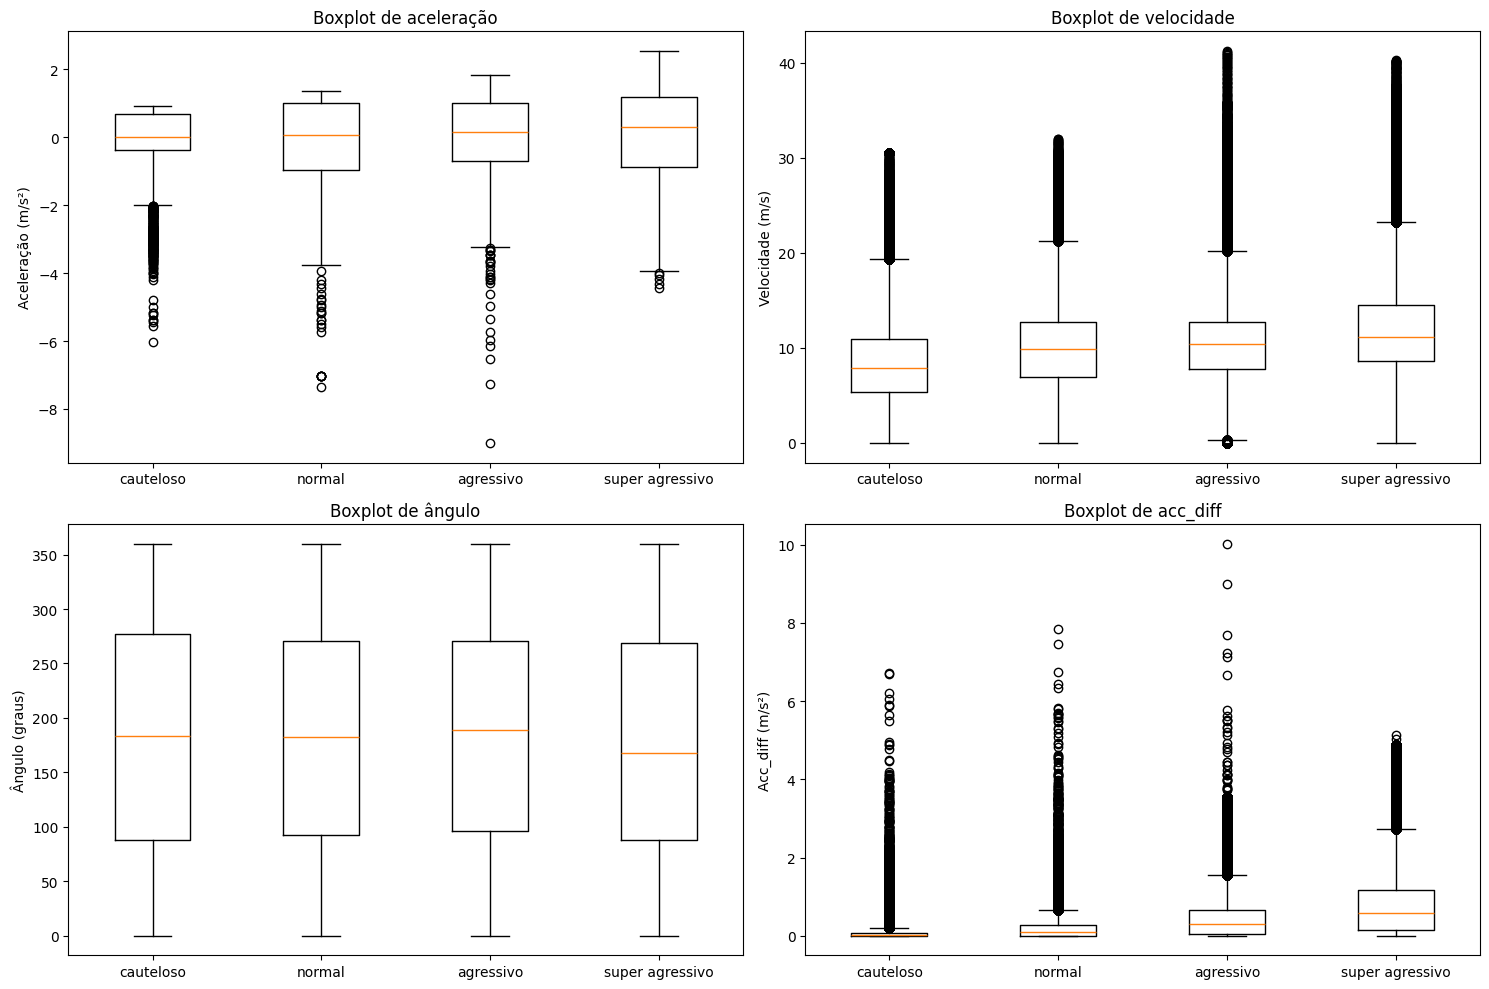

In [18]:
df = get_whole_data(f'{FOLDER_NAME}/data', type_ids_random)
boxplots(df, sensors=['acceleration', 'speed', 'angle', 'acc_diff'], showfliers=True, names=['aceleração (m/s²)', 'velocidade (m/s)', 'ângulo (graus)', 'acc_diff (m/s²)'], classes=['cauteloso', 'normal', 'agressivo', 'super agressivo'])

Dirty data

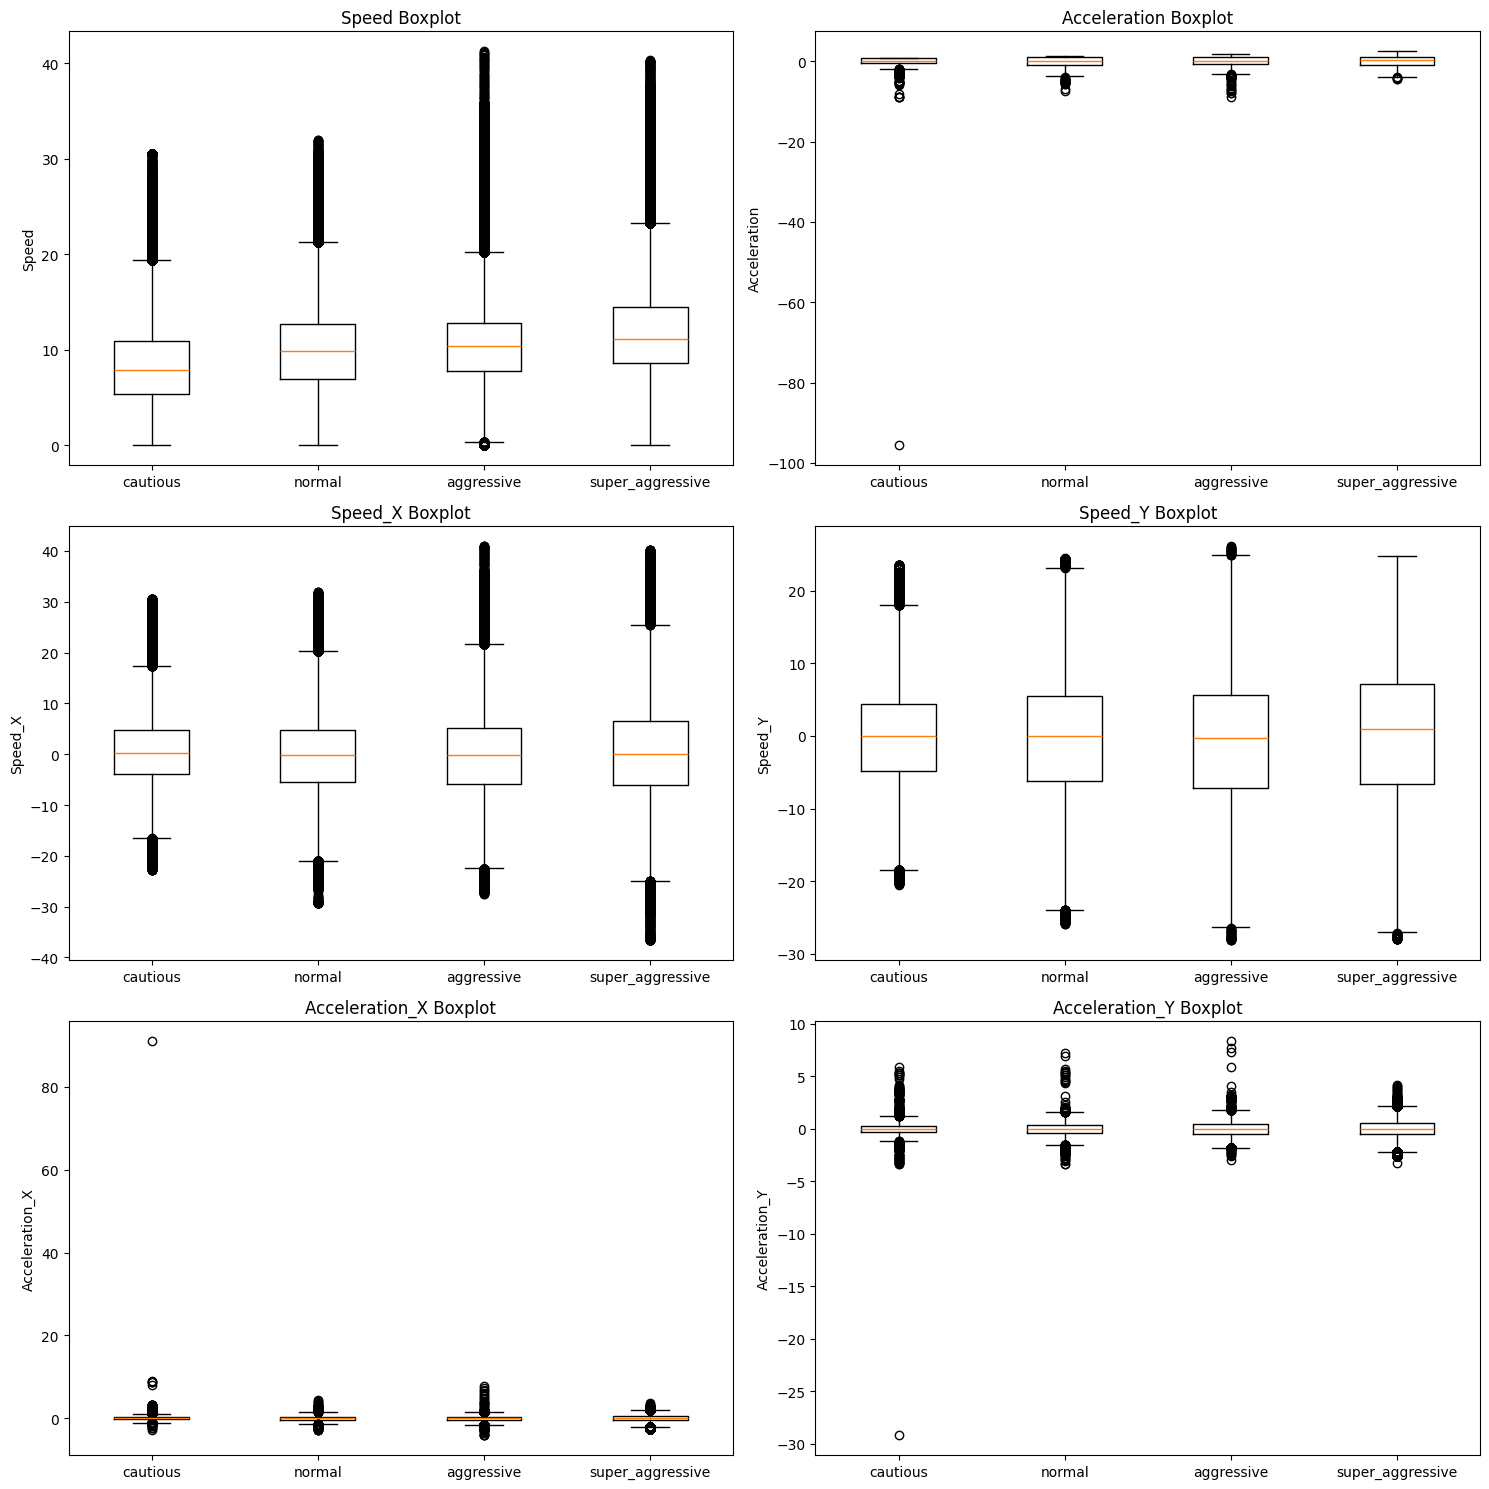

In [33]:
df_dirty = get_whole_data(f'{FOLDER_NAME}/data_dirty', type_ids_random)
boxplots(df_dirty)

## Example of time series for each class

In [25]:
def show_examples(data_folder, ids, sensors, window=None, plot_en=False):
    fig, axes = plt.subplots(nrows=len(ids)//2, ncols=2, figsize=(15, 2 * len(ids)), sharex=False)
    axes = axes.flatten()

    y_min, y_max = float('inf'), float('-inf')

    # Primeira passagem para determinar os limites de y
    for i in range(len(ids)):
        id = list(ids.values())[i]
        time_series = pd.read_csv(f'{data_folder}/{id}.csv')
        for sensor in sensors:
            y_min = min(y_min, time_series[sensor][:window].min())
            y_max = max(y_max, time_series[sensor][:window].max())

    # Segunda passagem para plotar os dados com limites de y compartilhados
    for i in range(len(ids)):
        id = list(ids.values())[i]
        cls = list(ids.keys())[i]
        time_series = pd.read_csv(f'{data_folder}/{id}.csv')
        for sensor in sensors:
            axes[i].plot(time_series['time'], time_series[sensor], label=sensor.capitalize())

            if not plot_en:
                if cls == 'cautious':
                    cls = 'cauteloso'
                elif cls == 'aggressive':
                    cls = 'agressivo'
                elif cls == 'super_aggressive':
                    cls = 'super agressivo'

            if plot_en:
                axes[i].set_title(f"{cls.capitalize()} vehicle over time")
            else:
                axes[i].set_title(f"Veículo {cls} ao longo do tempo")
            
            
            if window:
                axes[i].set_xlim([time_series['time'].min(), time_series['time'].min() + window])
            else:
                axes[i].set_xlim([time_series['time'].min(), time_series['time'].max()])
            axes[i].set_ylim([y_min - 1, y_max + 1])

    if plot_en:
        for ax in axes:
            ax.set_xlabel("Simulation step")
            ax.set_ylabel("Speed (m/s) / Acceleration (m/s²)")
            ax.legend(['Speed', 'Acceleration'])

    else:
        for ax in axes:
            ax.set_xlabel("Passo de simulação")
            ax.set_ylabel("Velocidade (m/s) / Aceleração (m/s²)")
            ax.legend(['Velocidade', 'Aceleração'])

    plt.tight_layout()
    plt.show()

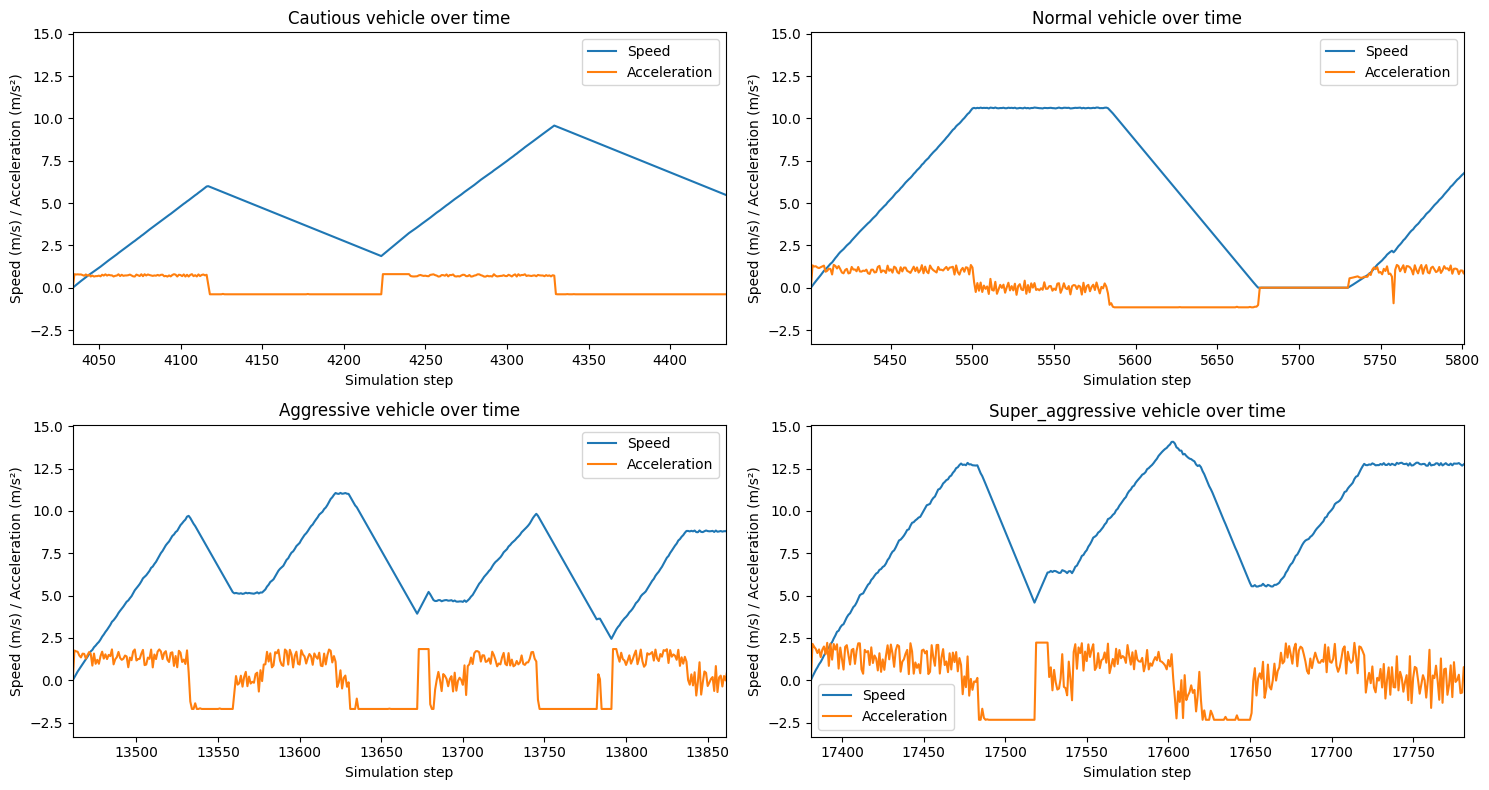

In [26]:
show_examples(f"{FOLDER_NAME}/data", {x: type_ids_random[x][np.random.randint(0, len(type_ids_random[x]))] for x in type_ids_random.keys()}, ['speed', 'acceleration'], window=400, plot_en=True)

### Here we can clearly see that even though the means of the values are really similar to each other, the frequency of change of acceleration, for example, is a lot different. Maybe we can use that to better separate the data

## Boxplot for two classes

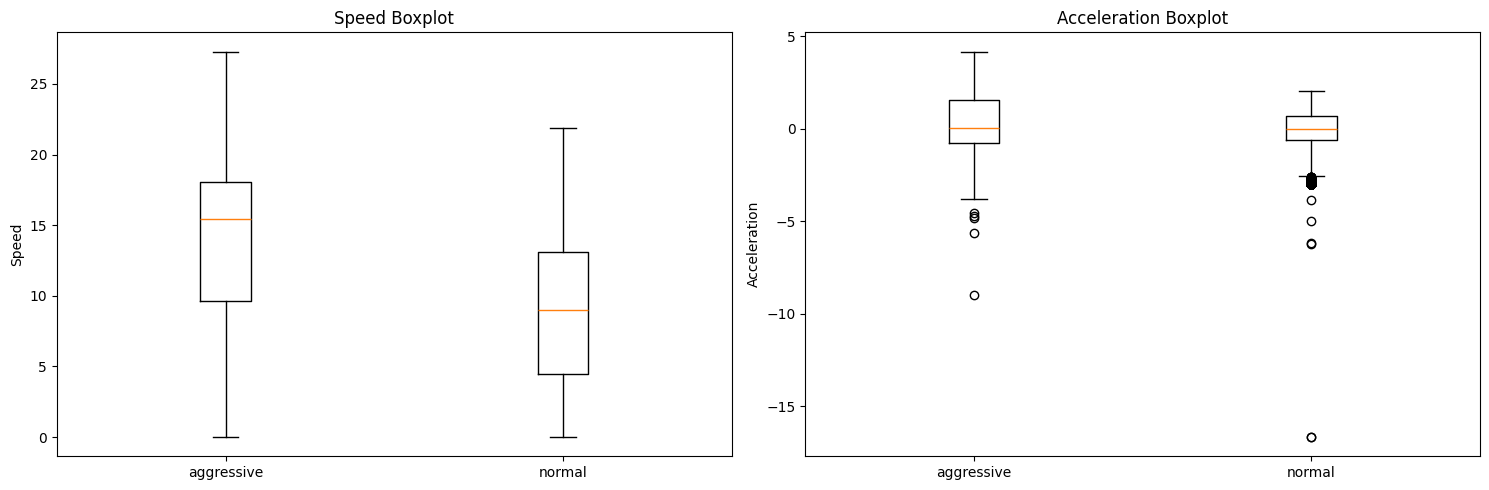

In [257]:
type_ids_routine_simple, type_ids_random_simple = extract_vtype_ids('unicamp')
df = get_whole_data(f'unicamp/data_simple', type_ids_random_simple)
boxplots(df)

## Decomposing sensors into X and Y axis

The idea here is to try to make it easier to separate the data by having more features

In [1]:
# TODO